In [1]:
using PyPlot
#using PGFPlots 
#using Winston


Qt: Untested Windows version 10.0 detected!
INFO: Loading help data...


In [32]:
include("sim.jl"); #include the simulator 
include("floopMap.jl") #include mapping

Import successful: sim.jl
Import successful: floopMap.jl


stateMap.nSize => 9765625
actionMap.nSize => 243
no self collsions founds


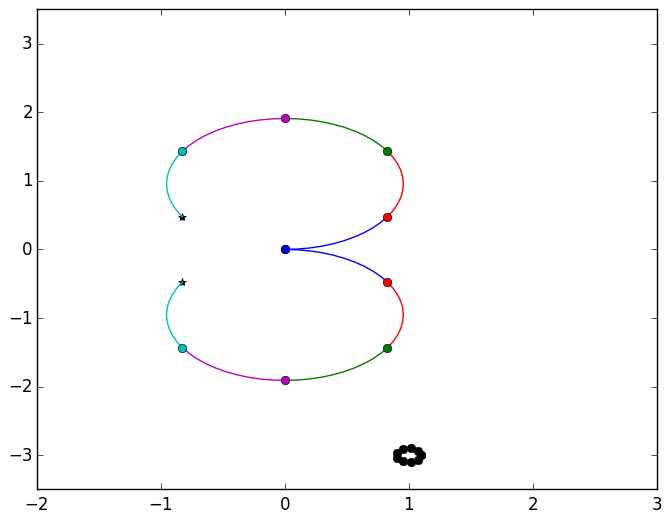

(-3.5,3.5)

In [61]:
#defne parameters
nSeg=5 #number of segments
aStep=5 #angle step 
aLimit=60
res=10 #resolution of segment 
l=1/res #set subsegment lenght so that segment lenght =1

#make maps
stateMap=makeMap([-aLimit:aStep:aLimit], nSeg)
actionMap=makeMap([-aStep:aStep:aStep], nSeg)

#set state
stateInd=rand(1:stateMap.nSize)
#stateInd=10
actionInd=rand(1:actionMap.nSize)

minState=ind2eval(1, stateMap)
maxState=ind2eval(stateMap.nSize, stateMap)

##make arm 
(arm,edges)=ccArm2(minState);
drawArm(arm, edges)

(arm,edges)=ccArm2(maxState);
drawArm(arm, edges)

@show stateMap.nSize
@show actionMap.nSize


##check self collide
selfCollide(arm, .060)



#set goal
goal=Zone([1 -3], .1)
drawZone(goal)

##make obs
#obby=Zone([1.5 -.5], .3)
#drawObs(Obs(c, r))

#check obs collision
#obsCollide(arm, Obs(c, r), 1.1)

#ploted for style
pmax=maximum(abs(arm))*1.1
#plot(p[:, 1],p[:, 2])
#xlabel("x")
#ylabel("y")
xlim(-2, 3)
ylim(-3.5, 3.5)
#savefig("arm.png")

In [58]:
ePos=zeros(stateMap.nSize,2) #get end effector pos for each state
tic()
for s=1:stateMap.nSize
    state=ind2eval(s, stateMap)
    ePos[s,:]=ccEnd(state)
end
toc()
ePos

elapsed time: 218.868398424 seconds


9765625x2 Array{Float64,2}:
 -0.826993   -0.477465
 -0.794348   -0.588378
 -0.751037   -0.696547
 -0.697312   -0.801006
 -0.633514   -0.900813
 -0.560064   -0.995057
 -0.477465   -1.08287 
 -0.386297   -1.16341 
 -0.287212   -1.23593 
 -0.180929   -1.2997  
 -0.0682314  -1.35407 
  0.0500435  -1.39847 
  0.173007   -1.43239 
  ⋮                   
  0.0500435   1.39847 
 -0.0682314   1.35407 
 -0.180929    1.2997  
 -0.287212    1.23593 
 -0.386297    1.16341 
 -0.477465    1.08287 
 -0.560064    0.995057
 -0.633514    0.900813
 -0.697312    0.801006
 -0.751037    0.696547
 -0.794348    0.588378
 -0.826993    0.477465

In [ ]:
#plot reachable set 
plot(ePos[:,1], ePos[:,2], "ko")
title("reachable set")
xlabel("x")
ylabel("y")
savefig("reach_$(nSeg)_$(aLimit).png")

In [62]:
#init value func
value=zeros(stateMap.nSize)
reward=zeros(stateMap.nSize)
nullAction=round(actionMap.nSize/2)
policy=int64(ones(stateMap.nSize)*nullAction)
tic()
for s=1:stateMap.nSize
    value[s]=norm(ePos[s,:]-goal.cent)<goal.radius? 100:0 
end
norm(value)

4849.742261192857

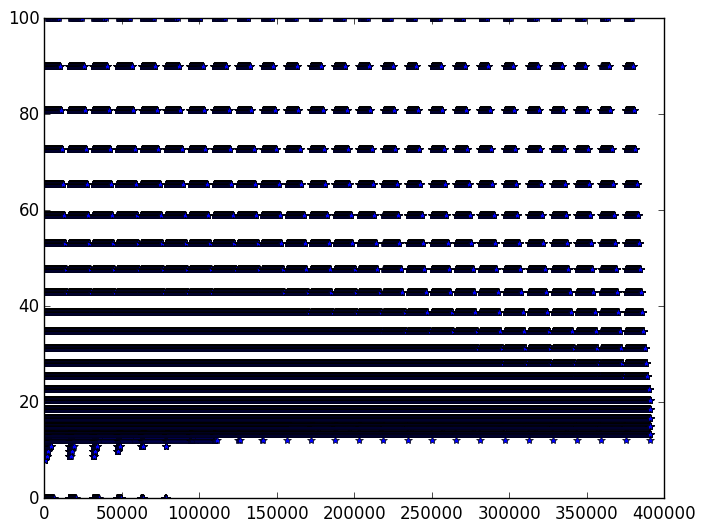

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000324A1278>

In [19]:
plot(value, "b*")

In [ ]:
#run value itr
γ=.9
for i=1:10
    tic()
    for s=1:stateMap.nSize
        if value[s]==100 # at goal state
            continue
        else #otherwise search action space
            for a =1:actionMap.nSize 
                #get next state
                s_=detTrans(s, a, stateMap, actionMap)
                #get reward #update value
                score=γ*value[s_]
                if score>value[s]
                    value[s]=score
                    policy[s]=a
                end 
            end 
        end
    end
    toc()
    println("Itr: $(i)")
    @show norm(value)
    if s>10
        break
    end
end

In [15]:
stateMap.nSize/100 * .8 /60

52.083333333333336

In [60]:
#export policy 
outfile= open("policy_$(nSeg)_$(aLimit)_$(aStep).txt", "w")
policy=int64(ones(stateMap.nSize))
for i=1:length(policy)
    write(outfile, "$(policy[i])\n")
end
close(outfile)

In [ ]:
#import policy 
policy=int64(ones(stateMap.nSize))
f= open("policy_c.txt", "r")
a=readlines(f)
for i in eachindex(a)
    policy[i]=parseint(Int64,a[i])
end
close(f)
policy

In [ ]:
stateMap.nSize/100 * .7 /60

In [46]:
state=randEval(stateMap)
sInd=eval2ind(int64(state), stateMap)

284323

sInd = rand(1:stateMap.nSize) => 271774
state = ind2eval(sInd,stateMap) => {55,40,-15,25}
norm(ccEnd(state) - goal) => 6.378891858561979
norm(ccEnd(state) - goal) => 6.10992425794998
norm(ccEnd(state) - goal) => 5.5067399528706975
norm(ccEnd(state) - goal) => 4.62346913673202
norm(ccEnd(state) - goal) => 3.8810335982746937
norm(ccEnd(state) - goal) => 3.0569403384255267
norm(ccEnd(state) - goal) => 2.176293890177299
norm(ccEnd(state) - goal) => 1.2671047692752506
norm(ccEnd(state) - goal) => 0.3760335089190885
norm(ccEnd(state) - goal) => 0.09728493431138208


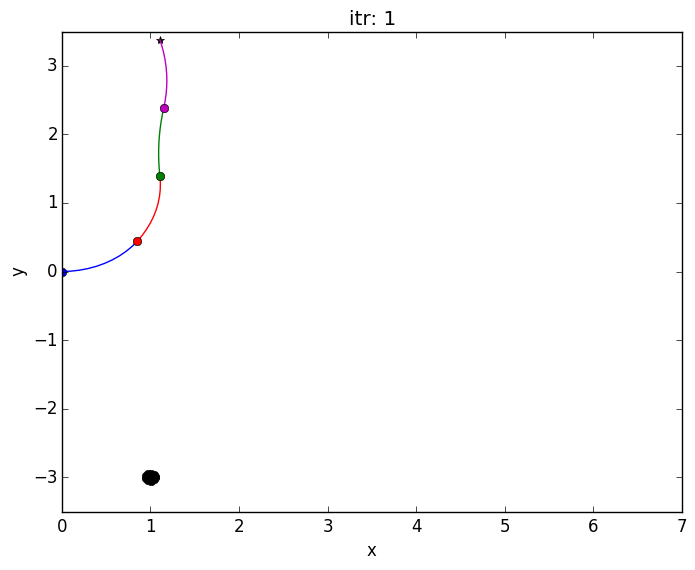

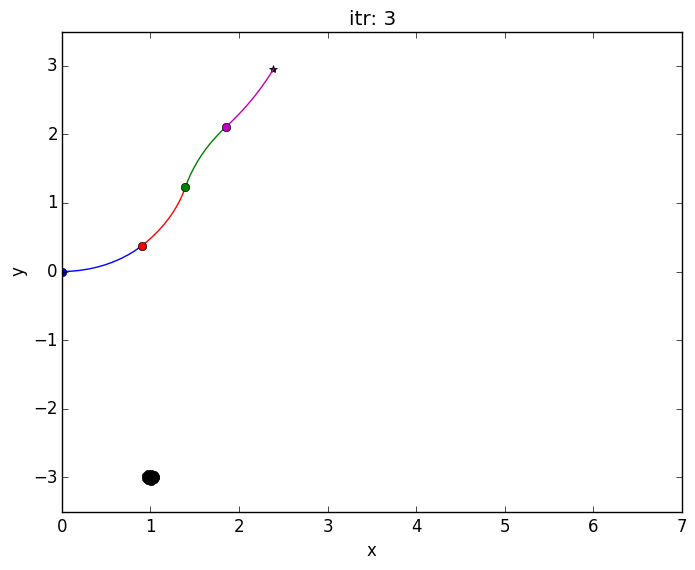

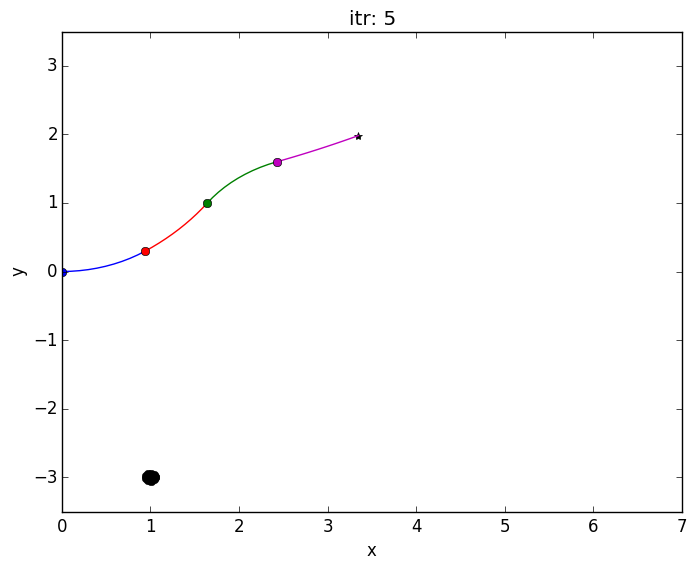

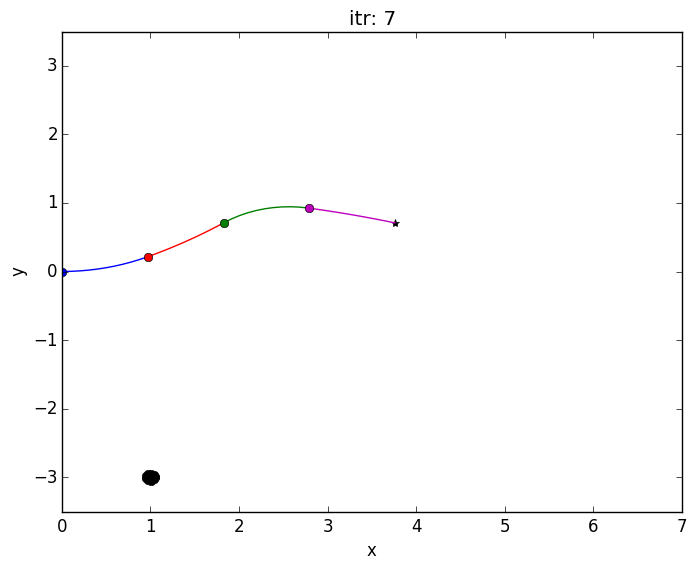

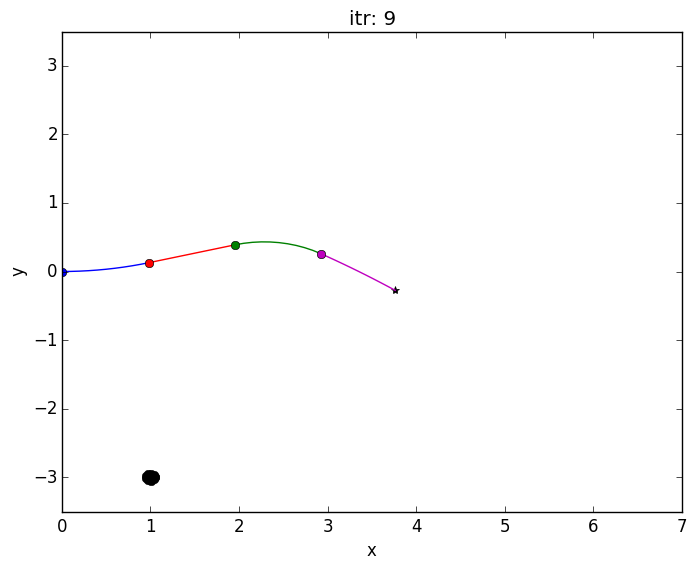

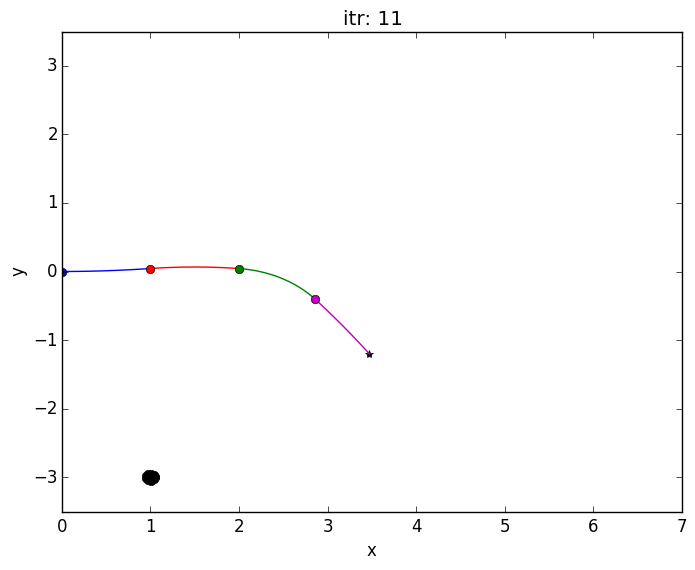

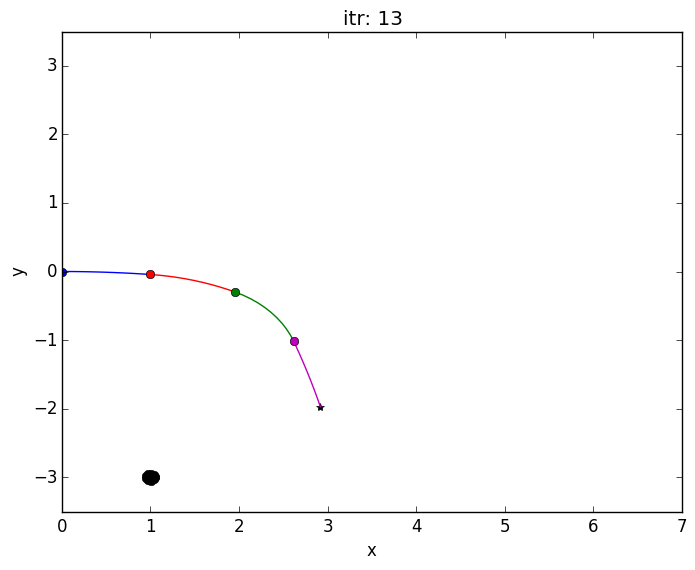

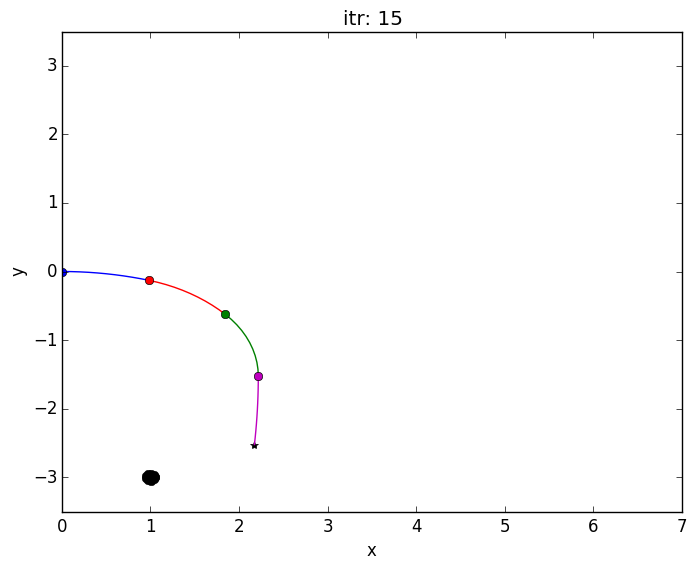

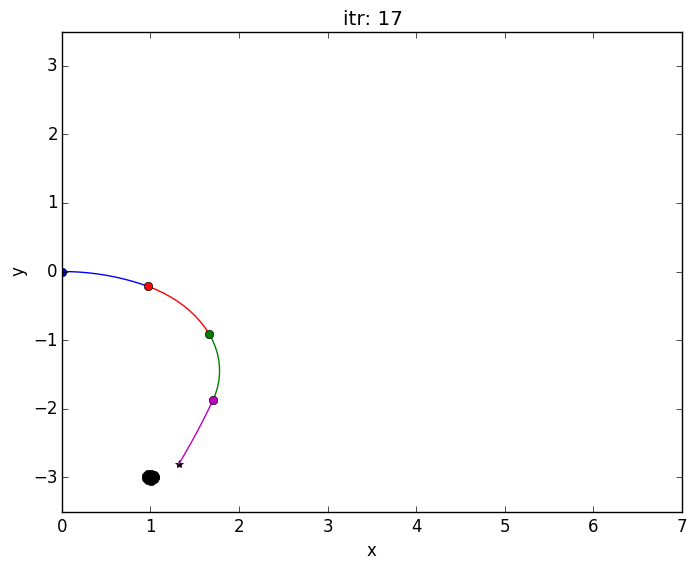

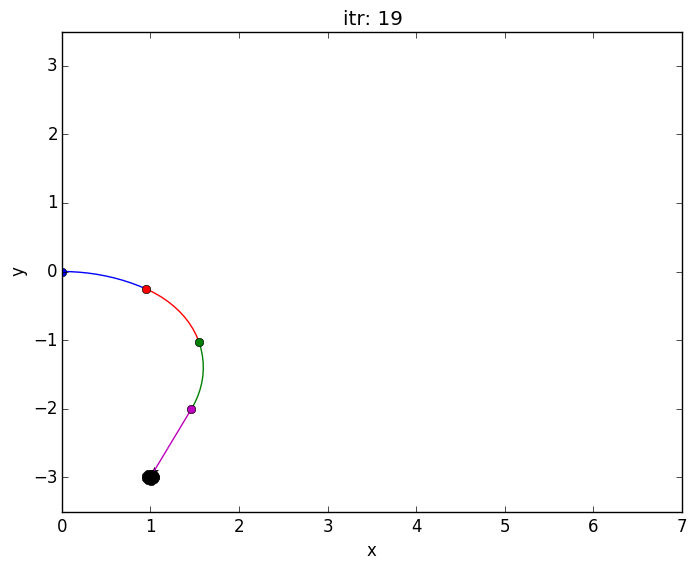

4-element Array{Any,1}:
  50
 -50
  55
  30

In [56]:
#eval policy 
@show sInd=rand(1:stateMap.nSize)
@show state=ind2eval(sInd, stateMap)
goal=[1 -3]
goalTrh=.05
nStep=20
for i=1:nStep
    if (i-1)%(nStep/10)==0
        ##make arm 
         figure()
        (arm,edges)=ccArm2(state);
        drawArm(arm, edges);
        Goal=Zone(goal, goalTrh)
        drawZone(Goal)
        title("itr: $(i)")
        xlabel("x")
        ylabel("y")
        xlim(-0, 7)
        ylim(-3.5, 3.5)
        savefig("test2//$(i).png")
        @show norm(ccEnd(state)-goal)
    end
    #get action
    aInd=policy[sInd]
    #trans
    sInd=detTrans(sInd, aInd, stateMap, actionMap)
    #get next state
    state=ind2eval(sInd, stateMap)
end
state=ind2eval(stateInd, stateMap)
##make arm 

In [55]:
ccQuick(map(deg2rad, state), 1)[end,:]

1x2 Array{Float64,2}:
 3.99965  0.0449289

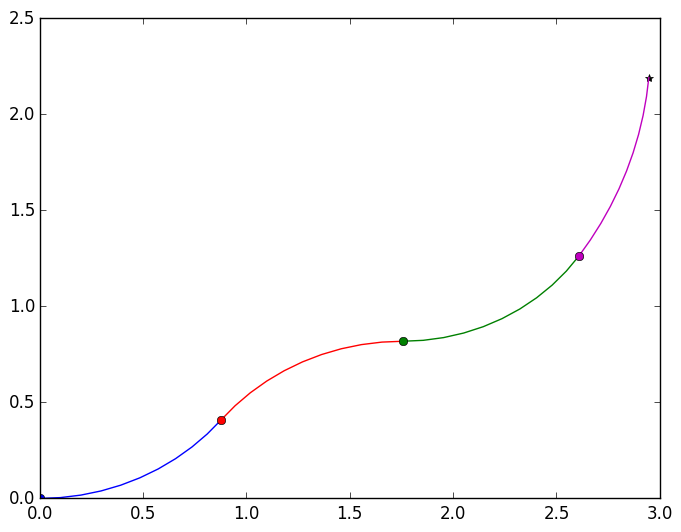

In [33]:
drawArm(state)

In [ ]:
plot(policy, "b*")

In [ ]:
plot(value, "b*")
ylim(-5, 105)

In [ ]:
eEff-goal'

In [ ]:
@show stateMap.nSize
@show actionMap.nSize

In [ ]:
ind2eval(122, actionMap)

In [ ]:
a=int64(ones(5)*25)
b=tuple(a...)

In [ ]:
sub2ind((25, 25, 25, 25, 25), (15, 2, 1, 1, 1))

In [ ]:
nStates=41^n
value=zeros(nStates)
tic()
for i=1:nStates
    value[i]+=1
end
toc()

In [ ]:
function smash(e)
	n=size(e,1)
	e=e'
	#checks for colisions 
	for i=1:(n-2)
		for j=(i+1):(n-1)
			t=inv(hcat(e[:,i+1]-e[:,i], e[:,j+1]-e[:,j]))*e[:,i]-e[:,j]
			col=vcat(t.<0,t.>1 )
			if norm(col)==0
				return e[:,i]+t[1]*(e[:,i+1]-e[:,i])
			end
		end	
	end
    return 0
end

In [ ]:
smash(e)

In [ ]:
#defne parameters
l=1 #segment len
n=10 #number of segments 
res=1000
#k=[.4 -1 1 1 1]
gain=2
pdif=rand(n)*gain
#pdif=ones(n)*1
(p,t)=cantArm(pdif, res, l, 1);
gcol=["b","r", "g", "m", "c", "b","r", "g", "m", "c"]
plot([p[end,1]],[p[end, 2]], "k*")
#plot([p[:,1]],[p[:, 2]], "k")
for i=1:n
    inx=(i-1)*res+1
    plot(p[inx:inx+res, 1],p[inx:inx+res, 2], gcol[i])
end
#plot(p[:, 1],p[:, 2])
xlabel("x")
ylabel("y")
#xlim(0, 13)
#ylim(-3, 3 )
#savefig("arm.png")

In [ ]:
function TestccSeg(k, res, l=1)
    t=linspace(0, k*l, res+1) #calcuate angle change
    p=zeros(res+1, 2)
    y=zeros(res+1)
    for i=1:res 
        p[i+1, 1]=p[i, 1]+(sin(t[i+1])-sin(t[i]))/k #update x 
        p[i+1, 2]=p[i, 2]+(-cos(t[i+1])+cos(t[i]))/k #update y
    end
    return (p[:, 1], p[:, 2], t[end])
end

In [ ]:
(x, y, t)=ccSeg(5, 100, 1)
plot(x, y)

In [ ]:
plot(t,"k*")


In [ ]:
x=[0:.1:1]
y=zeros(length(x))
t=zeros(length(x))
for i=1:length(x)
    y[i]=deflec(x[i], 1)
    t[i]=curv(x[i], 1)
end
plot(x,y)